In [1]:
import numpy as np
import random as random
import torch
import torch.nn as nn 
import pandas as pd
import torchdiffeq as ode
import matplotlib.pyplot as plt
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.linear_model import Ridge
from scipy.signal import find_peaks
from scipy.linalg import eig, qr
import joblib 
from scipy.optimize import fsolve
from scipy.optimize import root
from scipy import stats
import warnings
import argparse

seed = 0
np.random.seed(seed)
random.seed(seed)

def gen_ks(h,T,tpoints,ds,Nx,deltas,sigma,u,x,N):
    xs = x[::int(N//Nx)]
    tmax = T
    nmax = round(tmax/h)
    
    Xs = np.zeros((tpoints,Nx))#Used to record the status at all times
    nplt = int((tmax/tpoints)/h)
    ux = u[np.arange(0,len(u),int(N/Nx))]
    v = np.fft.fft(u)
    uu = np.array([ux])
    tt = 0
    
    for n in range(1, nmax): 
        d = ds[n-1]
        k = np.transpose(np.conj(np.concatenate((np.arange(0, N/2), np.array([0]), np.arange(-N/2+1, 0)))))*(2*np.pi/d) 
        
        g = -0.5j*k
        rh = deltas[n-1]
        L = k**2 - rh * k**4
        E = np.exp(h*L)
        E_2 = np.exp(h*L/2)
        M = 16
        r = np.exp(1j*np.pi*(np.arange(1, M+1)-0.5) / M) 
        LR = h*np.transpose(np.repeat([L], M, axis=0)) + np.repeat([r], N, axis=0)
        Q = h*np.real(np.mean((np.exp(LR/2)-1)/LR, axis=1))
        f1 = h*np.real(np.mean((-4-LR+np.exp(LR)*(4-3*LR+LR**2))/LR**3, axis=1))
        f2 = h*np.real(np.mean((2+LR+np.exp(LR)*(-2+LR))/LR**3, axis=1))
        f3 = h*np.real(np.mean((-4-3*LR-LR**2+np.exp(LR)*(4-LR))/LR**3, axis=1))
        
        rifftv = np.real(np.fft.ifft(v))
        Nv = g*np.fft.fft(rifftv**2)
        a = E_2*v + Q*Nv
        riffta = np.real(np.fft.ifft(a))
        Na = g*np.fft.fft(riffta**2)
        b = E_2*v + Q*Na
        rifftb = np.real(np.fft.ifft(b))
        Nb = g*np.fft.fft(rifftb**2)
        c = E_2*a + Q*(2*Nb-Nv)
        rifftc = np.real(np.fft.ifft(c))
        Nc = g*np.fft.fft(rifftc**2)
        v = E*v + Nv*f1 + 2*(Na+Nb)*f2 + Nc*f3
        if n%nplt == 0:
            #print(n//nplt,"/",tpoints)
            u = np.real(np.fft.ifft(v))
            # add noise
            #noise = (np.random.rand(N)-0.5)*2*sigma
            noise = np.random.randn(N)*sigma
            u = u + noise
            v = np.fft.fft(u)
            ux = u[np.arange(0,len(u),int(N/Nx))]
            uu = np.append(uu, np.array([ux]), axis=0)
            tt = np.hstack((tt, n))
    if True not in np.isnan(uu):
        Xs[:,:] = uu
    return(Xs,xs,u)


In [2]:
#ds_num = [38,37,36,35,34,33]
#ds_num = [36, 35.5, 35, 34.5, 34, 33.5, 33]
#ds_num = [35.5, 35, 34.5, 34, 33.5]
ds_num = np.linspace(35.8,33.7,10)

dt = 0.25
h = 0.05
tp_num = 10000
tpoints = tp_num * len(ds_num)
T = int(dt*tpoints)
ts = np.arange(tpoints) * dt
#deltas = np.linspace(1.1,0.94,int(T/h))
deltas = np.ones(int(T/h))

F_bifurcation = deltas[::int(T/dt/tpoints)]
method = "euler"
sigma = 0.00

ds = np.zeros(0)
for i in range(len(ds_num)):
    dsf = np.ones(int(dt/h)*10000)*ds_num[i]
    ds = np.concatenate((ds,dsf),axis=0)
    
Nx = 64; N = 64
x = ds[0]*np.transpose(np.conj(np.arange(-N/2+1, N/2+1))) / N
u = np.sin(x/4)*10
Nx = 64; N = 64
x = ds[0]*np.transpose(np.conj(np.arange(-N/2+1, N/2+1))) / N
u = np.sin(x/4)*10

nu = 2000
X_ini,xs_ini,u = gen_ks(h,h*nu,nu,np.ones(nu)*ds[0],Nx,np.ones(nu)*deltas[0],sigma,u,x,N)
X_ini,xs_ini,u = gen_ks(h,T,tpoints,ds,Nx,deltas,sigma,u,x,N)

X = X_ini[:,::1].copy()
xs = xs_ini[::1].copy()

print("Data successfully generated!")


Data successfully generated!


In [3]:
np.save('d_dat.npy', ds)
np.save('ks_dat.npy', X)

In [4]:
loaded_ds = np.load('d_dat.npy')
loaded_X = np.load('ks_dat.npy')

In [5]:
print(ds.shape)
print(X.shape)

(500000,)
(100000, 64)


/tmp/ipykernel_21284/2425934649.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[0].pcolormesh(tt_mesh, xx_mesh, true, vmin=true.min()*mr, vmax=true.max()*mr, cmap=cmap)


(0.0, 24999.75)

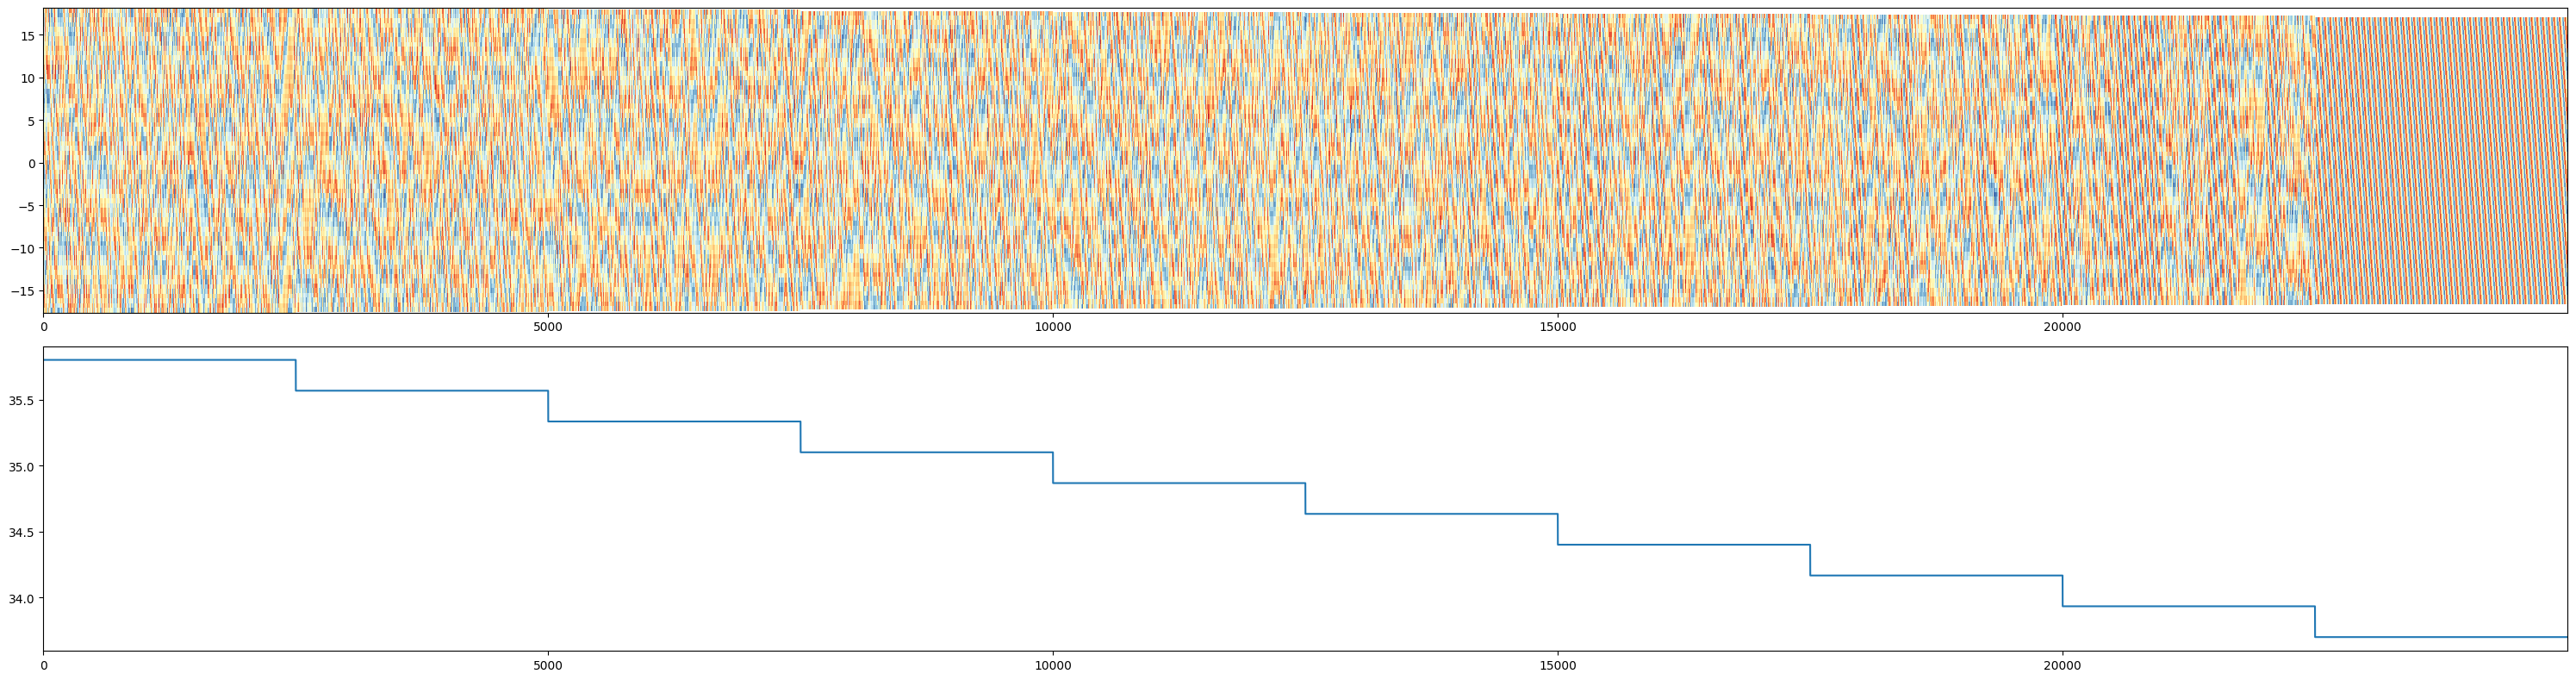

In [6]:
mr = 1.0
cmap = 'RdYlBu'
fig, ax = plt.subplots(2, 1, figsize=(30,8))
fig.set_tight_layout(True)
tt_mesh, xx_mesh = np.meshgrid(ts, xs)
for i in range(len(ds_num)):
    xx_meshi = ds_num[i]*np.transpose(np.conj(np.arange(-N/2+1, N/2+1))) / N
    xx_mesh[:,i*tp_num:(i+1)*tp_num] = xx_meshi[:,None].repeat(tp_num,1)
true = loaded_X.transpose()
ax[0].pcolormesh(tt_mesh, xx_mesh, true, vmin=true.min()*mr, vmax=true.max()*mr, cmap=cmap)

ax[1].plot(ts,loaded_ds[::int(dt/h)])
ax[1].set_xlim(ts[0],ts[-1])